In [ ]:
pip install keras-tcn

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
     |████████████████████████████████| 462 kB 36.2 MB/s 


In [ ]:
'''
from google.colab import drive 
drive.mount('/content/drive')
'''

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.utils import to_categorical
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM, Flatten, Conv1D, Dense, Flatten, Activation, UpSampling1D, MaxPooling1D, ZeroPadding1D
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils.vis_utils import plot_model
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_auc_score, classification_report
from tcn import TCN, tcn_full_summary

import sys
from tqdm import tqdm
import os 
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
 


In [ ]:
df= pd.read_csv('Data/dataset_full.csv' , sep = ',')

In [ ]:
df.dtypes == 'int64'
def remove_negatives(df):
    df[df == -1] = 0
remove_negatives(df)

In [ ]:
dataset = df.values
input_x = dataset[:,:-1]
output_x = dataset[:, -1]


In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='all')
X, y = oversample.fit_resample(input_x, output_x)

In [ ]:
validation_size = 0.25
x_train, x_test, y_train, y_test = train_test_split(X , y, test_size=validation_size,shuffle=True)

In [ ]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [ ]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(87000, 111, 1)
y_train:(87000, 2)

x_test:(29000, 111, 1)
y_test:(29000, 2)

input_shape:(111, 1)



In [ ]:
input_layer = Input(shape=(input_shape ))
batch_size, time_steps, input_dim = None, 111, 1

tcn_layer = TCN(input_shape=(time_steps, input_dim))
m3 = Sequential([
    tcn_layer,
    Dense(2, activation='softmax')
])

m3.compile(loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Adam(lr = 10e-4)  ,
       metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=m3.fit(x_train, y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/100
680/680 [==============================] - 50s 55ms/step - loss: 221.0266 - accuracy: 0.8691 - val_loss: 49.0045 - val_accuracy: 0.9237
Epoch 2/100
680/680 [==============================] - 35s 51ms/step - loss: 25.0219 - accuracy: 0.9129 - val_loss: 10.8083 - val_accuracy: 0.8926
Epoch 3/100
680/680 [==============================] - 35s 51ms/step - loss: 11.1630 - accuracy: 0.9189 - val_loss: 23.4870 - val_accuracy: 0.9189
Epoch 4/100
680/680 [==============================] - 35s 51ms/step - loss: 5.3783 - accuracy: 0.9225 - val_loss: 2.1483 - val_accuracy: 0.9324
Epoch 5/100
680/680 [==============================] - 35s 52ms/step - loss: 2.2337 - accuracy: 0.9261 - val_loss: 1.1769 - val_accuracy: 0.9316
Epoch 6/100
680/680 [==============================] - 35s 51ms/step - loss: 0.6752 - accuracy: 0.9279 - val_loss: 0.3612 - val_accuracy: 0.9279
Epoch 7/100
680/680 [==============================] - 34s 51ms/step - loss: 0.2730 - accuracy: 0.9360 - val_loss: 0.1757 -

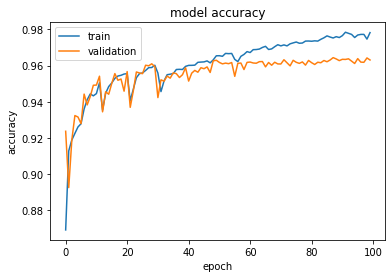

In [ ]:
 # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

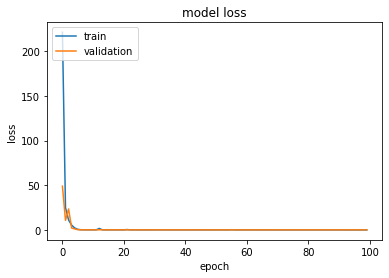

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
score = m3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12594196200370789
Test accuracy: 0.9631034731864929


In [ ]:
preds = m3.predict(x_test)
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
AUC: 96.31%


In [ ]:
from sklearn.metrics import confusion_matrix
y_predict=np.argmax(y_pred,axis=-1)
y=np.argmax(y_test,axis=-1)
cnf_matrix = confusion_matrix(y_predict, y)
cnf_matrix

array([[13974,   540],
       [  530, 13956]])

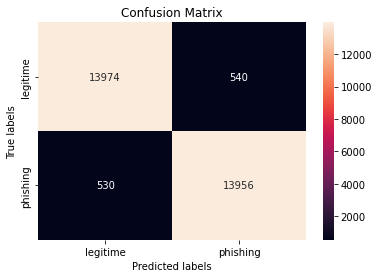

In [ ]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax,fmt="d");
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['legitime','phishing']);
ax.yaxis.set_ticklabels(['legitime','phishing']);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     14504
           1       0.96      0.96      0.96     14496

   micro avg       0.96      0.96      0.96     29000
   macro avg       0.96      0.96      0.96     29000
weighted avg       0.96      0.96      0.96     29000
 samples avg       0.96      0.96      0.96     29000



In [ ]:
input_layer = Input(shape=(input_shape ))
batch_size, time_steps, input_dim = None, 111, 1

tcn_layer = TCN(input_shape=(time_steps, input_dim))
m2 = Sequential([
    tcn_layer,
    Dense(2, activation='softmax')
])

In [ ]:
m2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adamax(lr = 10e-2)  ,
           metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [ ]:
history=m2.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10
680/680 [==============================] - 35s 52ms/step - loss: 0.2045 - accuracy: 0.9210 - val_loss: 0.2040 - val_accuracy: 0.9185
Epoch 2/10
680/680 [==============================] - 37s 54ms/step - loss: 0.2062 - accuracy: 0.9203 - val_loss: 0.2314 - val_accuracy: 0.9174
Epoch 3/10
680/680 [==============================] - 35s 51ms/step - loss: 0.2059 - accuracy: 0.9193 - val_loss: 0.1919 - val_accuracy: 0.9239
Epoch 4/10
680/680 [==============================] - 35s 52ms/step - loss: 0.2218 - accuracy: 0.9230 - val_loss: 0.2365 - val_accuracy: 0.9106
Epoch 5/10
680/680 [==============================] - 35s 51ms/step - loss: 0.2070 - accuracy: 0.9184 - val_loss: 0.2191 - val_accuracy: 0.9201
Epoch 6/10
680/680 [==============================] - 35s 51ms/step - loss: 0.1926 - accuracy: 0.9238 - val_loss: 0.1856 - val_accuracy: 0.9262
Epoch 7/10
680/680 [==============================] - 37s 54ms/step - loss: 0.1859 - accuracy: 0.9273 - val_loss: 0.1939 - val_accuracy:

In [ ]:
score = m2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17662356793880463
Test accuracy: 0.9310689568519592


In [ ]:
preds = m2.predict(x_test)
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
AUC: 93.14%


In [ ]:
from sklearn.metrics import confusion_matrix
y_predict=np.argmax(y_pred,axis=-1)
y=np.argmax(y_test,axis=-1)
cnf_matrix = confusion_matrix(y_predict, y)
cnf_matrix

array([[13308,   803],
       [ 1196, 13693]])

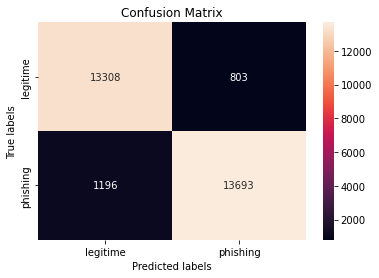

In [ ]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax,fmt="d");
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['legitime','phishing']);
ax.yaxis.set_ticklabels(['legitime','phishing']);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     14504
           1       0.92      0.94      0.93     14496

   micro avg       0.93      0.93      0.93     29000
   macro avg       0.93      0.93      0.93     29000
weighted avg       0.93      0.93      0.93     29000
 samples avg       0.93      0.93      0.93     29000



In [ ]:
input_layer = Input(shape=(input_shape ))
batch_size, time_steps, input_dim = None, 111, 1

tcn_layer = TCN(input_shape=(time_steps, input_dim))
m3 = Sequential([
    tcn_layer,
    Dense(2, activation='softmax')
])

In [ ]:
m3.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(lr = 10e-4)  ,
           metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history=m3.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10
680/680 [==============================] - 41s 56ms/step - loss: 258.4699 - accuracy: 0.8481 - val_loss: 0.2320 - val_accuracy: 0.9234
Epoch 2/10
680/680 [==============================] - 37s 55ms/step - loss: 0.3477 - accuracy: 0.9137 - val_loss: 0.2139 - val_accuracy: 0.9202
Epoch 3/10
680/680 [==============================] - 38s 55ms/step - loss: 0.3895 - accuracy: 0.9247 - val_loss: 0.1735 - val_accuracy: 0.9356
Epoch 4/10
680/680 [==============================] - 38s 56ms/step - loss: 0.3848 - accuracy: 0.9272 - val_loss: 0.1679 - val_accuracy: 0.9327
Epoch 5/10
680/680 [==============================] - 37s 55ms/step - loss: 0.3455 - accuracy: 0.9336 - val_loss: 0.1748 - val_accuracy: 0.9342
Epoch 6/10
680/680 [==============================] - 37s 55ms/step - loss: 0.2160 - accuracy: 0.9374 - val_loss: 0.1535 - val_accuracy: 0.9415
Epoch 7/10
680/680 [==============================] - 38s 55ms/step - loss: 0.2661 - accuracy: 0.9422 - val_loss: 0.1651 - val_accurac

In [ ]:
score = m3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1568867564201355
Test accuracy: 0.9431723952293396


In [ ]:
preds = m3.predict(x_test)
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
AUC: 94.51%


In [ ]:
from sklearn.metrics import confusion_matrix
y_predict=np.argmax(y_pred,axis=-1)
y=np.argmax(y_test,axis=-1)
cnf_matrix = confusion_matrix(y_predict, y)
cnf_matrix

array([[13199,   343],
       [ 1305, 14153]])

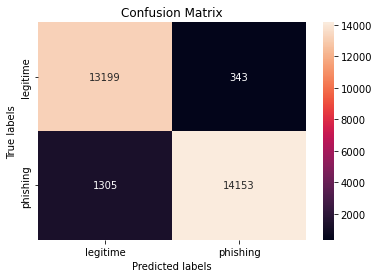

In [ ]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax,fmt="d");
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['legitime','phishing']);
ax.yaxis.set_ticklabels(['legitime','phishing']);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     14504
           1       0.92      0.98      0.94     14496

   micro avg       0.94      0.94      0.94     29000
   macro avg       0.95      0.94      0.94     29000
weighted avg       0.95      0.94      0.94     29000
 samples avg       0.94      0.94      0.94     29000

